# NYSE FANG+ index 日足 メディアン統計

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

code = 'NYFANG'
symbol = '^%s' % code
#symbol = 'USDJPY=X'
ticker = yf.Ticker(symbol)
df = ticker.history(period='1y', interval='1d')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-04-01 00:00:00-04:00,9998.009766,10118.650391,9989.009766,10066.480469,0,0.0,0.0
2024-04-02 00:00:00-04:00,10066.480469,10066.480469,9844.580078,9961.059570,0,0.0,0.0
2024-04-03 00:00:00-04:00,9961.059570,10054.549805,9908.110352,10024.419922,0,0.0,0.0
2024-04-04 00:00:00-04:00,10024.419922,10205.660156,9890.330078,9893.589844,0,0.0,0.0
2024-04-05 00:00:00-04:00,9893.589844,10114.379883,9893.589844,10040.490234,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-24 00:00:00-04:00,12055.480469,12332.650391,12055.480469,12307.809570,0,0.0,0.0
2025-03-25 00:00:00-04:00,12307.809570,12488.900391,12307.809570,12445.360352,0,0.0,0.0
2025-03-26 00:00:00-04:00,12445.360352,12445.360352,12038.370117,12079.509766,0,0.0,0.0


In [3]:
df0 = ticker.history(period='3y', interval='1d')
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-03-29 00:00:00-04:00,6784.399902,6922.799805,6784.399902,6881.850098,0,0.0,0.0
2022-03-30 00:00:00-04:00,6881.850098,6913.649902,6758.959961,6790.779785,0,0.0,0.0
2022-03-31 00:00:00-04:00,6790.779785,6797.839844,6594.319824,6594.319824,0,0.0,0.0
2022-04-01 00:00:00-04:00,6594.319824,6730.609863,6594.319824,6645.149902,0,0.0,0.0
2022-04-04 00:00:00-04:00,6645.149902,6924.290039,6645.149902,6920.790039,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-24 00:00:00-04:00,12055.480469,12332.650391,12055.480469,12307.809570,0,0.0,0.0
2025-03-25 00:00:00-04:00,12307.809570,12488.900391,12307.809570,12445.360352,0,0.0,0.0
2025-03-26 00:00:00-04:00,12445.360352,12445.360352,12038.370117,12079.509766,0,0.0,0.0


## Moving Median

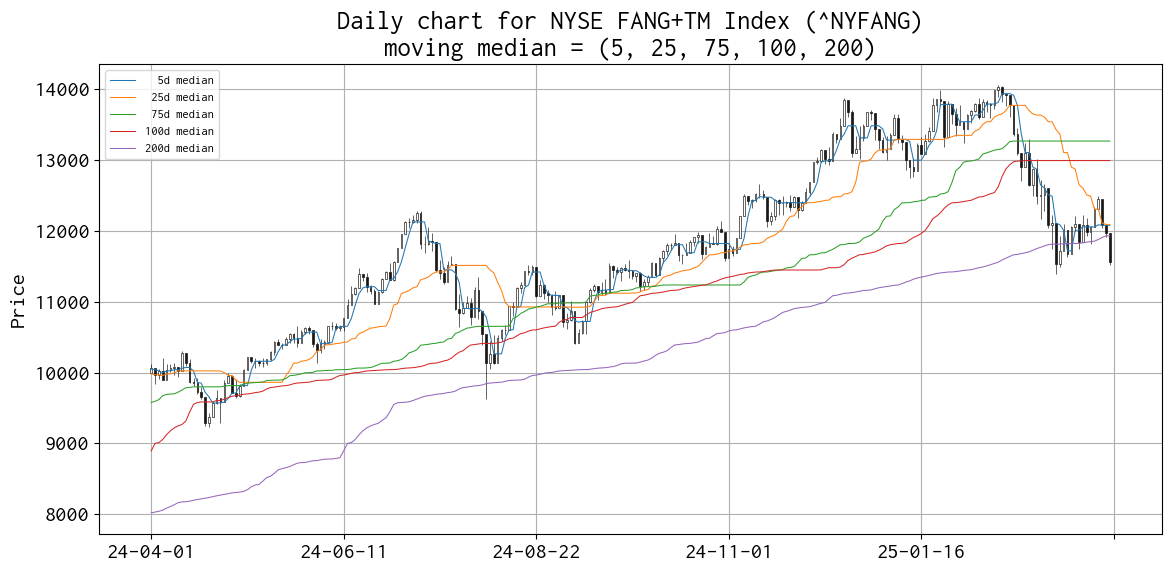

In [4]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 6))

mm005 = df0['Close'].rolling(5).median()
mm025 = df0['Close'].rolling(25).median()
mm075 = df0['Close'].rolling(75).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()

apds  = [
    mpf.make_addplot(mm005[df.index], width=0.75, label='  5d median', ax=ax),
    mpf.make_addplot(mm025[df.index], width=0.75, label=' 25d median', ax=ax),
    mpf.make_addplot(mm075[df.index], width=0.75, label=' 75d median', ax=ax),
    mpf.make_addplot(mm100[df.index], width=0.75, label='100d median', ax=ax),
    mpf.make_addplot(mm200[df.index], width=0.75, label='200d median', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
ax.set_title('Daily chart for %s (%s)\nmoving median = (5, 25, 75, 100, 200)' %(ticker.info['longName'], symbol))
ax.grid()
ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('report_daily_chart_median_%s.png' % code)
plt.show()

In [5]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-27 00:00:00-04:00,12079.509766,12102.839844,11917.759766,11965.290039,0,0.0,0.0
2025-03-28 00:00:00-04:00,11965.290039,11965.290039,11524.830078,11566.830078,0,0.0,0.0


In [6]:
df.tail(2)['Close']

Date
2025-03-27 00:00:00-04:00    11965.290039
2025-03-28 00:00:00-04:00    11566.830078
Name: Close, dtype: float64

In [7]:
df.tail(2)['Close'].diff()

Date
2025-03-27 00:00:00-04:00           NaN
2025-03-28 00:00:00-04:00   -398.459961
Name: Close, dtype: float64

In [8]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-03-28 00:00:00-04:00   -398.459961
dtype: float64

In [9]:
df['Close'].rolling(9).median().tail()

Date
2025-03-24 00:00:00-04:00    12055.480469
2025-03-25 00:00:00-04:00    12057.169922
2025-03-26 00:00:00-04:00    12079.509766
2025-03-27 00:00:00-04:00    12079.509766
2025-03-28 00:00:00-04:00    12055.480469
Name: Close, dtype: float64

In [10]:
df['Close'].rolling(13).median().tail()

Date
2025-03-24 00:00:00-04:00    12055.480469
2025-03-25 00:00:00-04:00    12055.480469
2025-03-26 00:00:00-04:00    12055.480469
2025-03-27 00:00:00-04:00    12055.480469
2025-03-28 00:00:00-04:00    12055.480469
Name: Close, dtype: float64

In [11]:
df['Close'].rolling(26).median().tail()

Date
2025-03-24 00:00:00-04:00    12399.104980
2025-03-25 00:00:00-04:00    12376.584961
2025-03-26 00:00:00-04:00    12208.729980
2025-03-27 00:00:00-04:00    12100.880371
2025-03-28 00:00:00-04:00    12089.790039
Name: Close, dtype: float64

In [12]:
df['Close'].rolling(52).median().tail()

Date
2025-03-24 00:00:00-04:00    13233.520020
2025-03-25 00:00:00-04:00    13156.084961
2025-03-26 00:00:00-04:00    13105.719727
2025-03-27 00:00:00-04:00    13105.719727
2025-03-28 00:00:00-04:00    13105.719727
Name: Close, dtype: float64

## Robust Bollinger's bands

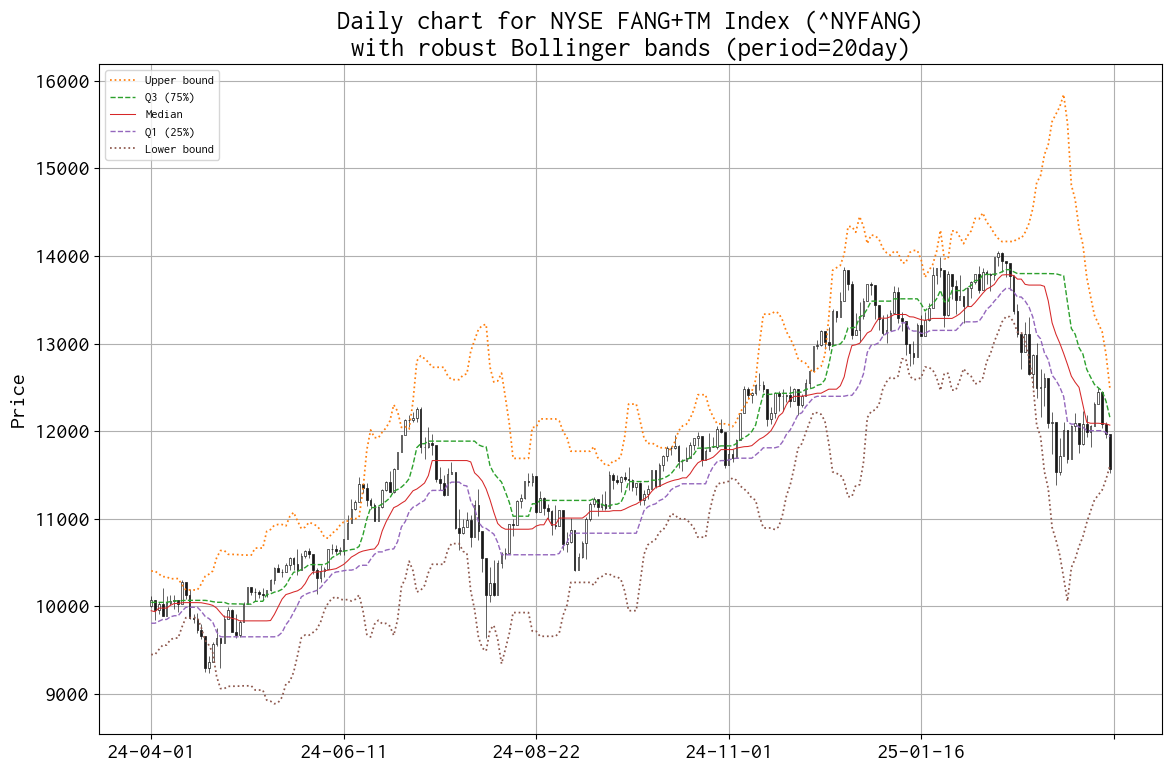

In [13]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 20
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    addplot=apds,
    datetime_format='%y-%m-%d',
    xrotation=0,
    ax=ax,
)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Daily chart for %s (%s)\nwith robust Bollinger bands (period=%dday)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Daily chart for %s\nwith robust Bollinger bands (period=%dday)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_daily_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラム

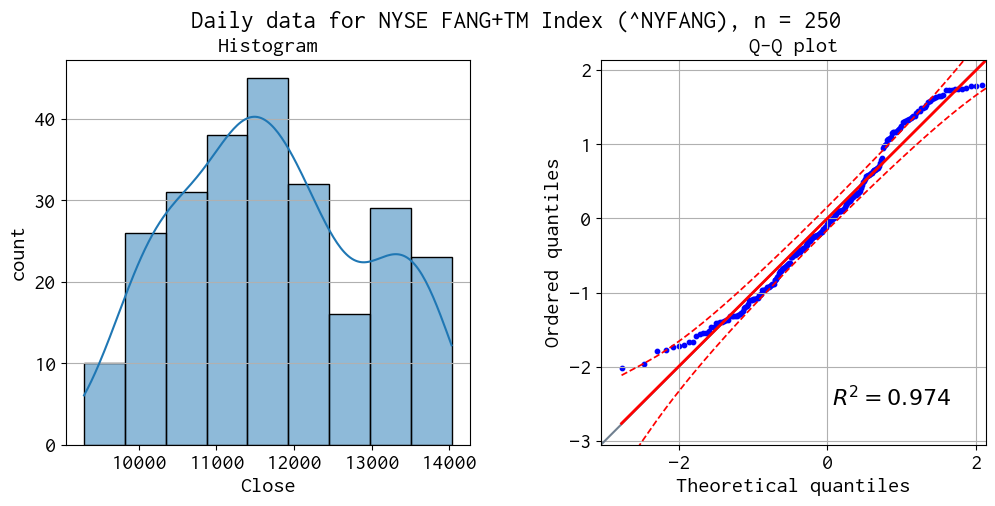

In [14]:
plt.rcParams['font.size'] = 16

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(
    df['Close'],
    kde=True,
    ax=axes[0]
)

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].grid(axis = 'y')
axes[0].set_title('Histogram', fontsize=16)

# Q-Q プロット
pg.qqplot(df['Close'], s=10,  ax=axes[1])
axes[1].set_title('Q-Q plot', fontsize=16)
axes[1].grid()

plt.suptitle('Daily data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)), fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.savefig('report_daily_histogram_qqplot_%s.png' % code)
plt.show()